## Test Configuration
| Duct Configuration  | Propeller Type       | Measured Propeller Diameter | Propeller Tip Profile | Duct Inner Diameter | Lip Configuration |
| --------------------|----------------------|-----------------------------|-----------------------|---------------------| ------------------|
| Open air / unducted | HQ Prop 5" Hex Blade |                             | Original / Unshaved   | N/A                 | None              |

## Procedure
Initiate throttle sweep from 0-100% throttle in increments of 5%, holding each step for 5 seconds. For each aerodynamic configuration, disassemble and reassemble between tests.

## Hypothesis
We expect the low blade count and low pitch propellers to be more power efficient, but produce less thrust.

## Impact
The results from this test will determine the props used in the rest of our testing. Props that produce significantly less thrust than required to lift a payload (~12 N) will be eliminated and a propeller with high power efficiency around the 12 N range will be selected, with slight preference toward high efficiency in the 8 N range (flight without payload) and high full throttle thrust.

This test will also validate full throttle performance of our motors. Another possible outcome of this test is that the low-KV motors do not spin our propellers fast enough to produce enough thrust for flight with a payload. If so, new motors will need to be purchased and these tests will have to be rerun with those motors, as both motors and propellers contribute to power efficiency.

## Analysis
Average battery voltage, motor currents, and thrust will be collected for each throttle step after the transients stabilize, and a thrust vs. electrical power plot will be made to compare all props.

## Observations

For our first few full throttle tests, we noticed our thrust start to decrease as throttle went above about 75%, the root cause of this was determined to be the movable carriage hitting the end stops, which were taking up some of the load since the jig was remounted to a new base and the relative positioning of components changed since the last test.

In [1]:
from runner import TestRunner, TestPlan, TestStep
import matplotlib.pyplot as plt
import numpy as np

In [24]:
# 1. Create a test plan consisting of steps.
steps = [TestStep(bottom_throttle=i, top_throttle=i, duration_ms=2_000) for i in np.arange(5, 101, 5)]
plan = TestPlan(
    "test",
    steps=steps
)
plan

TestPlan(name='test', steps=[TestStep(duration_ms=2000, top_throttle=5, bottom_throttle=5, pitch_angle=None, roll_angle=None), TestStep(duration_ms=2000, top_throttle=10, bottom_throttle=10, pitch_angle=None, roll_angle=None), TestStep(duration_ms=2000, top_throttle=15, bottom_throttle=15, pitch_angle=None, roll_angle=None), TestStep(duration_ms=2000, top_throttle=20, bottom_throttle=20, pitch_angle=None, roll_angle=None), TestStep(duration_ms=2000, top_throttle=25, bottom_throttle=25, pitch_angle=None, roll_angle=None), TestStep(duration_ms=2000, top_throttle=30, bottom_throttle=30, pitch_angle=None, roll_angle=None), TestStep(duration_ms=2000, top_throttle=35, bottom_throttle=35, pitch_angle=None, roll_angle=None), TestStep(duration_ms=2000, top_throttle=40, bottom_throttle=40, pitch_angle=None, roll_angle=None), TestStep(duration_ms=2000, top_throttle=45, bottom_throttle=45, pitch_angle=None, roll_angle=None), TestStep(duration_ms=2000, top_throttle=50, bottom_throttle=50, pitch_ang

In [73]:
# 2. Connect to jig and run the test.
runner = TestRunner(port="COM11", timeout=0.1)
runner.run(plan=plan)

Tx: Begin new test spec
FAIL Rx: 
Tx: time_ms,top_throttle,bottom_throttle,pitch_us,roll_us
FAIL Rx: 
FAIL Rx: Invalid command: 417,17,0,0

Arming...
FAIL Rx: 
Running test...
Rx: 
Skipped rx
Rx: 
Skipped rx
Rx: 
Skipped rx
Rx: 
Skipped rx
Rx: 
Skipped rx
Rx: 
Skipped rx
Rx: 
Skipped rx
Rx: 
Skipped rx
Rx: 
Skipped rx
Rx: 
Skipped rx
Rx: 
Skipped rx
Rx: 
Skipped rx
Rx: 
Skipped rx
Rx: 
Skipped rx
Rx: 
Skipped rx
Rx: 
Skipped rx
Rx: 
Skipped rx
Rx: Starting test

Skipped rx
Rx: time_us,top_rpm,bot_rpm,v_bat,i_bat,i_top,i_bot,thrust_N,torque_Nm

Skipped rx
Rx: 446,0,0,18.018000,10.240000,0.087240,-0.361660,-0.130701,-0.000675

Rx: 5174,0,0,17.240999,10.240000,0.145400,-0.292110,-0.130701,-0.000675

Rx: 8154,0,0,17.052000,10.240000,0.087240,-0.250380,-0.130701,-0.000675

Rx: 11162,0,0,16.926001,10.240000,0.101780,-0.222560,-0.130701,-0.000675

Rx: 14154,0,0,16.841999,10.240000,0.159940,-0.208650,-0.130701,-0.000675

Rx: 17162,0,0,16.841999,10.240000,0.087240,-0.250380,-0.130701,-0.000819


In [74]:
runner.save('two_cells_upto100_endstop_fixed.csv')

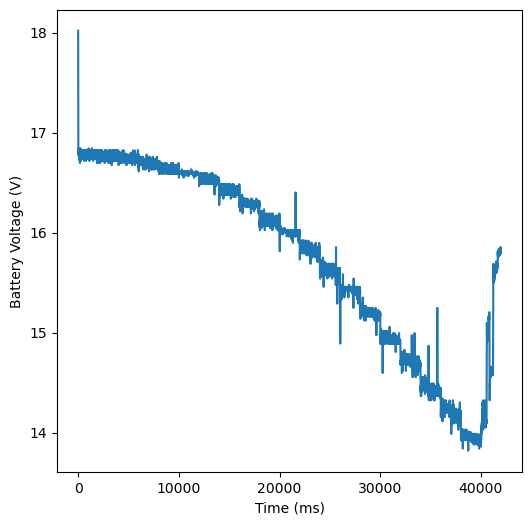

In [76]:
runner.plot('batt_voltage_V')

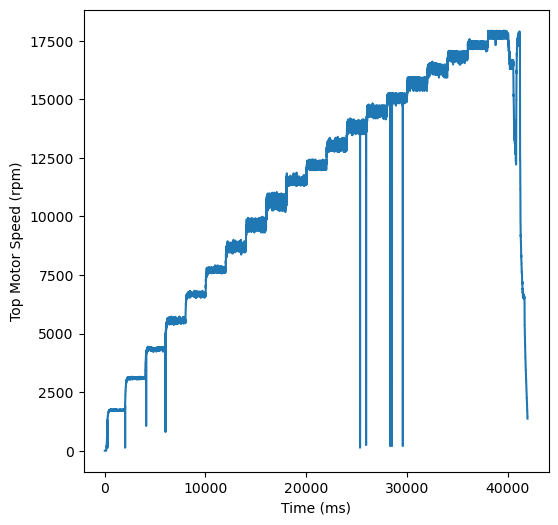

In [77]:
runner.plot('top_motor_rpm')

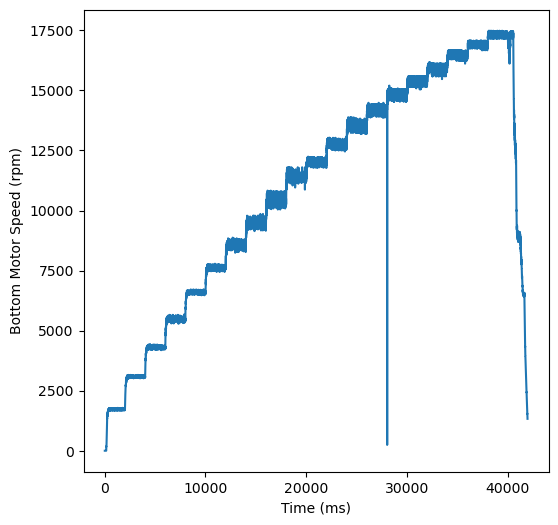

In [78]:
runner.plot('bottom_motor_rpm')

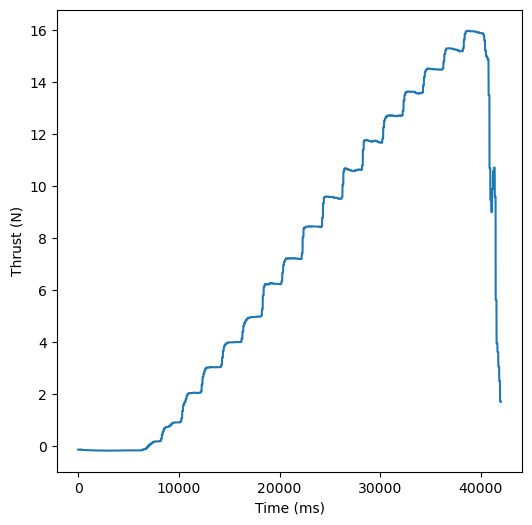

In [79]:
runner.plot('thrust_N')

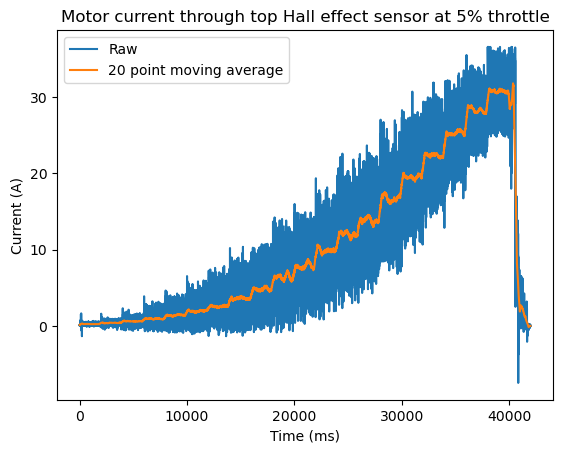

In [80]:
# 3. Plot data or get values as Numpy array.
# runner.plot("bottom_current_A")
time_ms = runner.values("time_ms")
bottom_current = runner.values("top_current_A")
plt.plot(time_ms, bottom_current, label='Raw')
flt_current = np.convolve(bottom_current, np.ones(100), 'same') / 100
plt.plot(time_ms, flt_current, label='20 point moving average')
plt.xlabel('Time (ms)')
plt.ylabel('Current (A)')
plt.title('Motor current through top Hall effect sensor at 5% throttle')
plt.legend()

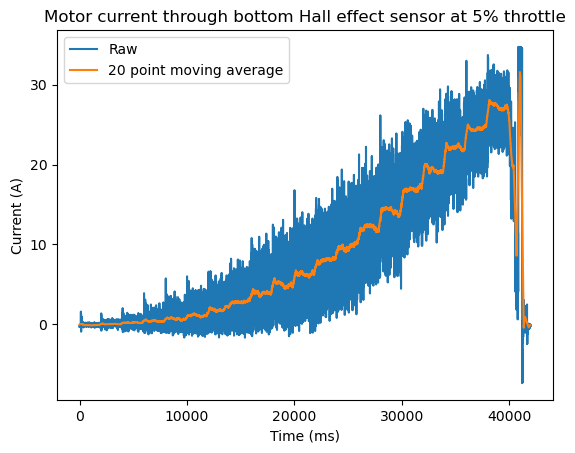

In [81]:
# 3. Plot data or get values as Numpy array.
# runner.plot("bottom_current_A")
time_ms = runner.values("time_ms")
bottom_current = runner.values("bottom_current_A")
plt.plot(time_ms, bottom_current, label='Raw')
flt_current = np.convolve(bottom_current, np.ones(100), 'same') / 100
plt.plot(time_ms, flt_current, label='20 point moving average')
plt.xlabel('Time (ms)')
plt.ylabel('Current (A)')
plt.title('Motor current through bottom Hall effect sensor at 5% throttle')
plt.legend()

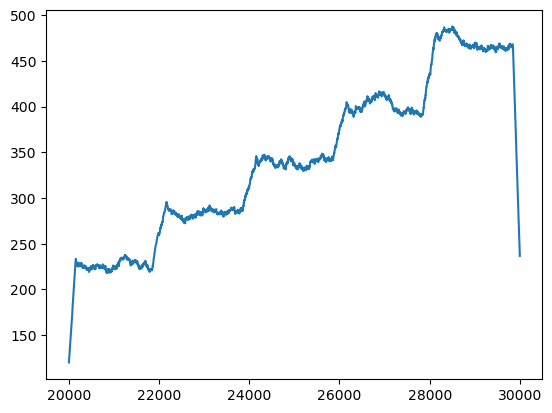

In [82]:
total_current = runner.values("top_current_A", 20_000, 30_000) + runner.values("bottom_current_A", 20_000, 30_000)
voltage = runner.values("batt_voltage_V", 20_000, 30_000)
power = total_current * voltage

time_ms = runner.values("time_ms", 20_000, 30_000)
LPF_N = 100
power_filtered = np.convolve(power, np.ones(LPF_N)/LPF_N, 'same')
# plt.plot(time_ms, power)
plt.plot(time_ms, power_filtered)

1.8617072297346193 317.4629022361256


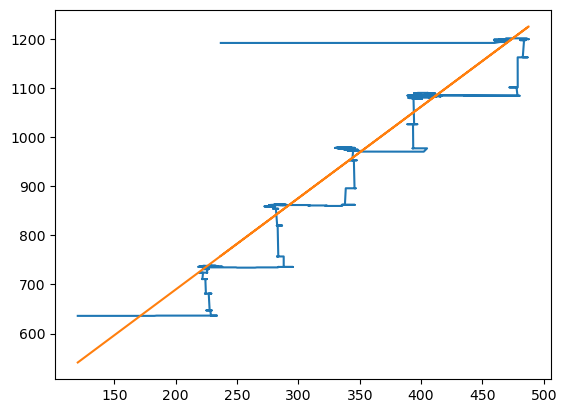

In [83]:
thrust = runner.values("thrust_N", 20_000, 30_000) / 9.81 * 1000
plt.plot(power_filtered, thrust)

m, b = np.polyfit(power_filtered, thrust, 1)
print(m, b)

plt.plot(power_filtered, power_filtered * m + b)